# Initial Data ETL and EDA

## 2. Data Exploration

In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
# Loading
import json
# import pyspark
# from pyspark.sql import SparkSession

# Statistics
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Basic text processing
import html
import re
import string
import pickle
# import spacy
# from common import vocabulary

# NLTK processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Additional processing
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from collections import Counter
from unicodedata import normalize
# from wordcloud import WordCloud

### 2.1 Load data using PySpark

In [ ]:
spark = SparkSession.builder.appName('Test').getOrCreate()

In [ ]:
mags_meta = spark.read.json('data/magazine_subscriptions_meta.json')
mags = spark.read.json('data/magazine_subscriptions.json')

In [ ]:
books = spark.read.json('data/books.json')
books_meta = spark.read.json('data/books_meta.json')

In [ ]:
mags.printSchema()

In [ ]:
mags_meta.printSchema()

In [ ]:
books_meta.printSchema()

In [ ]:
book_reviews.printSchema()

In [ ]:
books_meta.count()

In [ ]:
books.count()

In [ ]:
mag_categories = mags_meta.groupBy('category')
mag_categories.count().show()

In [ ]:
mags_pd = mags.toPandas()
mags_meta_pd = mags_meta.toPandas()

### 2.2 Load data using pandas

In [3]:
# Note - runtime is untenable on the books data in local jupyter notebook

# books_meta = pd.read_json('../data/books_meta.json', lines=True)
# books = pd.read_json('../data/books.json', lines=True)
meta = pd.read_json('../data/magazine_subscriptions_meta.json', lines=True)
reviews = pd.read_json('../data/magazine_subscriptions.json', lines=True)

In [4]:
# Drop duplicate records of a unique ASIN
meta.drop_duplicates(subset='asin', inplace=True)

# Drop reviews with no reviewText
reviews = reviews[reviews['reviewText'].isna() == False]

# Convert vote column to numeric
reviews['vote'] = reviews['vote'].str.replace(',', '').fillna(0).astype(int)

In [5]:
print("\033[1m" + "Dataframe Shape" + "\033[0m")
print(reviews.shape)
print("\n")

print("\033[1m" + "Column Information" + "\033[0m")
reviews.info()
print("\n")

Dataframe Shape
(89656, 12)


Column Information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89656 entries, 0 to 89688
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         89656 non-null  int64 
 1   vote            89656 non-null  int64 
 2   verified        89656 non-null  bool  
 3   reviewTime      89656 non-null  object
 4   reviewerID      89656 non-null  object
 5   asin            89656 non-null  object
 6   reviewerName    89654 non-null  object
 7   reviewText      89656 non-null  object
 8   summary         89640 non-null  object
 9   unixReviewTime  89656 non-null  int64 
 10  style           51378 non-null  object
 11  image           133 non-null    object
dtypes: bool(1), int64(3), object(8)
memory usage: 8.3+ MB




In [6]:
reviews['reviewText'][1]

'Thank god this is not a Ziff Davis publication.  MaxPC will actually tell you if a product is bad. They will print just what they think about something; no sugar coating. I would compare their style to Car and Driver. Technical, but they know how to have a good time.'

In [7]:
reviews.iloc[0]

overall                                                           5
vote                                                              9
verified                                                      False
reviewTime                                               11 8, 2001
reviewerID                                            AH2IFH762VY5U
asin                                                     B00005N7P0
reviewerName                                           ted sedlmayr
reviewText        for computer enthusiast, MaxPC is a welcome si...
summary                      AVID READER SINCE "boot"  WAS THE NAME
unixReviewTime                                           1005177600
style                                                           NaN
image                                                           NaN
Name: 0, dtype: object

In [8]:
print("\033[1m" + "Dataframe Shape" + "\033[0m")
print(meta.shape)
print("\n")

print("\033[1m" + "Column Information" + "\033[0m")
meta.info()
print("\n")

Dataframe Shape
(2320, 19)


Column Information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2320 entries, 0 to 3384
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   category         2320 non-null   object        
 1   tech1            2320 non-null   object        
 2   description      2320 non-null   object        
 3   fit              2320 non-null   object        
 4   title            2320 non-null   object        
 5   also_buy         2320 non-null   object        
 6   tech2            2320 non-null   object        
 7   brand            2320 non-null   object        
 8   feature          2320 non-null   object        
 9   rank             2320 non-null   object        
 10  also_view        2320 non-null   object        
 11  details          2320 non-null   object        
 12  main_cat         2320 non-null   object        
 13  similar_item     2320 non-null   object      

In [9]:
meta.iloc[0].category

['Magazine Subscriptions',
 'Professional & Educational Journals',
 'Professional & Trade',
 'Humanities & Social Sciences',
 'Economics & Economic Theory']

### 2.3 Meta data transformation

In [10]:
categories = ['category', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
meta[categories] = pd.DataFrame(meta['category'].to_list())
meta.replace('amp;', '', regex=True, inplace=True)

In [11]:
meta['category'].value_counts(dropna=False)

NaN                       1201
Magazine Subscriptions    1119
Name: category, dtype: int64

In [12]:
subcat = 'subcat1'
meta[subcat].value_counts(dropna=False)

NaN                                    1201
Professional & Educational Journals     370
Sports, Recreation & Outdoors           137
Travel, City & Regional                 117
Fashion & Style                          61
Home & Garden                            44
Entertainment & Pop Culture              41
Arts, Music & Photography                40
Children & Teen                          39
Business & Investing                     32
Cooking, Food & Wine                     31
Lifestyle & Cultures                     26
Literary, Sci-Fi & Mystery               25
Crafts & Hobbies                         23
Automotive & Motorcycles                 21
Science, History & Nature                17
Religion & Spirituality                  16
Health, Fitness & Wellness               14
News & Political Commentary              14
Technology                               14
Women's Interest                         10
Pets & Animals                            8
Parenting & Families            

In [13]:
meta['brand'].value_counts(dropna=False)

Hearst Magazines              255
Conde Nast                    184
                              147
Meredith                       48
Bonnier Corporation            43
                             ... 
Supertrax                       1
National Assn of Rocketry       1
Columbia Journalism Review      1
Woodenboat Publications         1
TI Golf Holdings                1
Name: brand, Length: 943, dtype: int64

In [14]:
def count_if(group):
    '''Count the values of a boolean column that are True'''
    return np.sum(group==True)

# Use groupby and agg to summarize relevant statistics from review data by each ASIN
asin_stats = reviews.groupby('asin').agg({'asin': 'count',
                                          'overall': 'mean',
                                          'verified': count_if                                         
                                         })

# Rename columns and reset index
asin_stats.rename(columns={'asin':'reviews',
                           'overall':'avgRating',
                           'verified': 'reviewsVerified'
                          },
                  inplace=True
                 )
asin_stats.reset_index(inplace=True)

# Merge ASIN statistics df with original metadata, drop irrelevant columns
asins = pd.merge(meta,
                asin_stats,
                on='asin',
                how='left'
               )

asins = asins[['asin', 'subcat1', 'brand', 'reviews', 'reviewsVerified', 'avgRating']]
asins['pctVerified'] = asins['reviewsVerified'] / asins['reviews']
asins.head()

,asin,subcat1,brand,reviews,reviewsVerified,avgRating,pctVerified
0,B00005N7NQ,Professional & Educational Journals,Reason Magazine,117.0,56.0,3.803419,0.478632
1,B00005N7OC,"Arts, Music & Photography",String Letter Publishers,31.0,6.0,2.645161,0.193548
2,B00005N7OD,Fashion & Style,Conde Nast Publications,193.0,64.0,3.725389,0.331606
3,B00005N7O9,"Sports, Recreation & Outdoors",AirAge Publishing,23.0,16.0,4.434783,0.695652
4,B00005N7O6,Professional & Educational Journals,EPG Media & Specialty Information,64.0,50.0,4.531250,0.781250


In [15]:
print("\033[1m" + "Column Information" + "\033[0m")
print(asins.describe())

Column Information
           reviews  reviewsVerified    avgRating  pctVerified
count  2319.000000      2319.000000  2319.000000  2319.000000
mean     36.733937        24.641225     4.116051     0.684337
std     118.689026        84.413756     0.881121     0.325099
min       1.000000         0.000000     1.000000     0.000000
25%       2.000000         1.000000     3.750000     0.500000
50%       6.000000         4.000000     4.266667     0.753906
75%      20.000000        14.000000     4.800000     1.000000
max    1718.000000      1315.000000     5.000000     1.000000


### 2.4 Meta data visualization

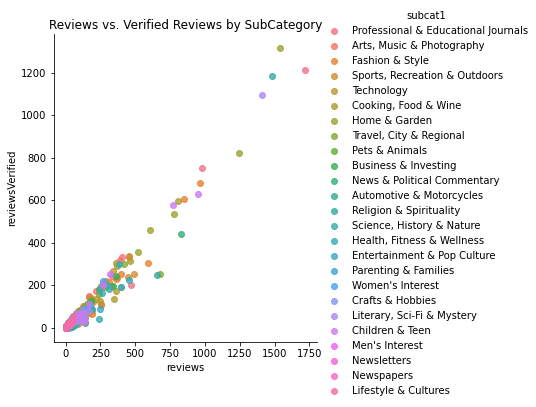

In [16]:
sns.lmplot(x='reviews', y='reviewsVerified', data=asins, hue='subcat1', fit_reg=False)\
   .set(title='Reviews vs. Verified Reviews by SubCategory')

plt.show()

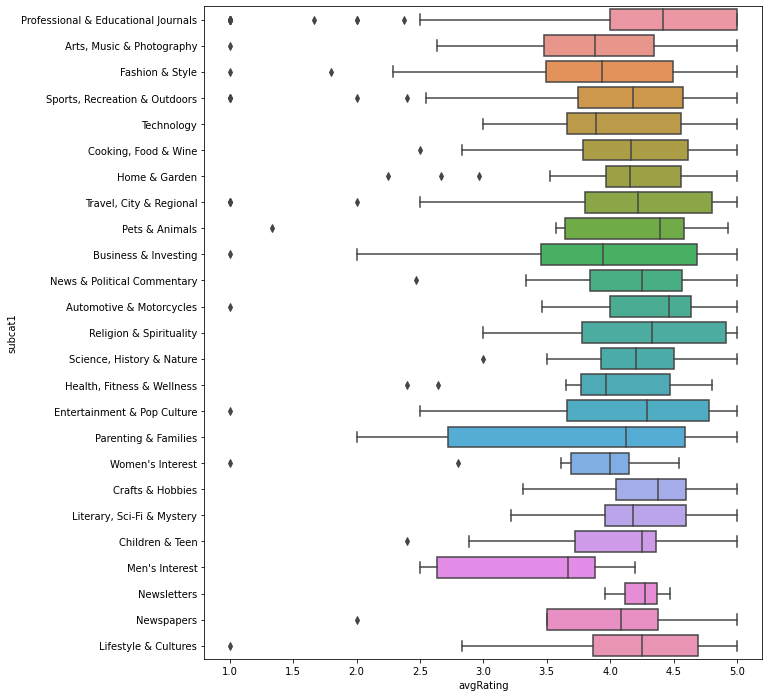

In [17]:
fig, ax = plt.subplots(figsize=(10,12))
sns.boxplot(x='avgRating', y='subcat1', orient='h', data=asins)
# sns.swarmplot(x='avgRating', y='subcat1', orient='h', data=asins, color='.1')
plt.show()

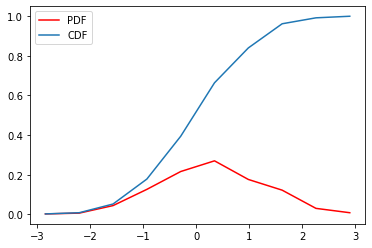

In [19]:
# defining the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
  
# No of Data points
N = 500
  
# initializing random values
data = np.random.randn(N)
  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=10)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()
plt.show()

### 2.5 Filter and random sampling

In [26]:
# Filter ASINs to reviews >= 10
asin_samples = asins[asins['reviews'] >= 5]

# Filter ASINs to subcat1 >= 10
# Need to consider whether I want to do this or not
# cat_counts = asin_samples['subcat1'].value_counts(dropna=False)
# asin_samples = asin_samples.loc[asin_samples['subcat1'].isin(cat_counts[cat_counts >= 30].index), :]

asin_samples.shape

(1365, 7)

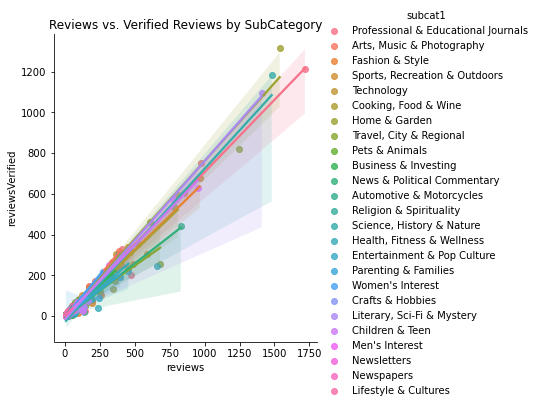

In [27]:
sns.lmplot(x='reviews', y='reviewsVerified', data=asin_samples, hue='subcat1', fit_reg=True)\
   .set(title='Reviews vs. Verified Reviews by SubCategory')

plt.show()

In [28]:
# Filter reviews based on asin_samples
review_samples = pd.merge(reviews,
                          asin_samples,
                          on='asin',
                          how='inner'
                         )

In [29]:
# Random sample 5 reviews from each ASIN
# This is likely over-sampling - DON'T USE 
# review_samples = review_samples.groupby('asin').sample(n=5, random_state=1)

In [30]:
print(reviews.shape)
print(review_samples.shape)

(89656, 12)
(83228, 18)


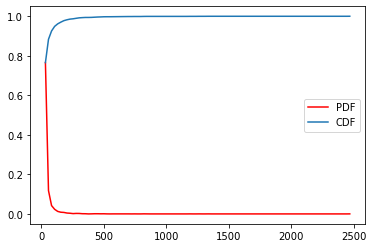

In [43]:
  
data = review_samples['vote']
  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=100)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()
plt.show()

In [ ]:
# Remove outliers greater than 3 std-dev above mean votes for usefulness
# This makes visualization more interpretable, but likely not a good idea for modeling
# Because we want the outliers to be considered the "most useful"

# outlier_threshold = review_samples.describe()['vote']['mean'] +\
#                     (review_samples.describe()['vote']['std'] * 3)

# review_samples = review_samples[review_samples['vote'] <= outlier_threshold]

In [41]:
# Remove reviews with X votes

min_votes = 10
review_samples = review_samples[review_samples['vote'] >= min_votes]

In [42]:
print(reviews.shape)
print(review_samples.shape)

(89656, 12)
(5583, 18)


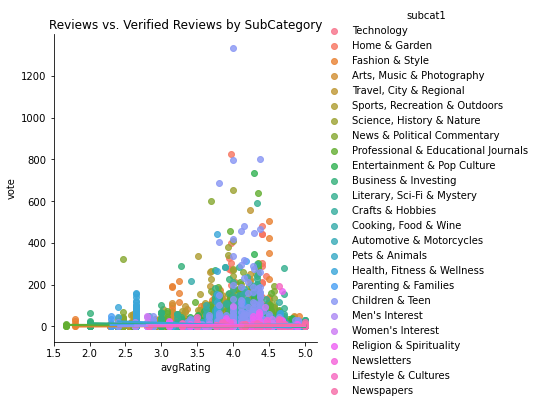

In [33]:
sns.lmplot(x='avgRating', y='vote', data=review_samples, hue='subcat1', fit_reg=True)\
   .set(title='Reviews vs. Verified Reviews by SubCategory')

plt.show()

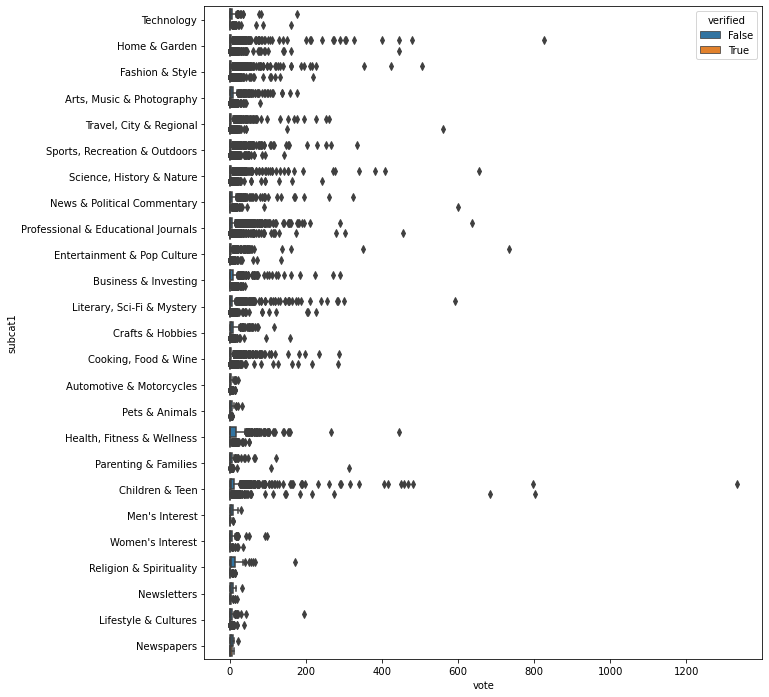

In [34]:
fig, ax = plt.subplots(figsize=(10,12))
sns.boxplot(x='vote', y='subcat1', hue='verified', orient='h', data=review_samples)
# sns.swarmplot(x='vote', y='subcat1', hue='verified', orient='h', data=review_samples)
plt.show()

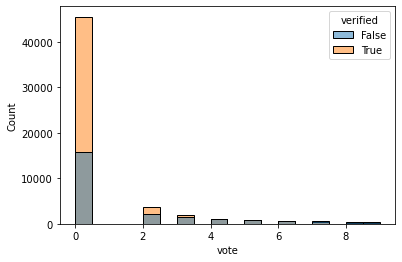

In [35]:
sns.histplot(x='vote',
             hue='verified',
             data=review_samples[review_samples['vote'] < 10])
plt.show()

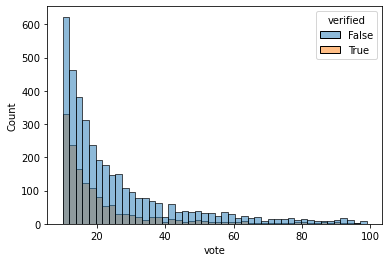

In [36]:
sns.histplot(x='vote',
             hue='verified',
             data=review_samples[(review_samples['vote'] >= 10) & (review_samples['vote'] < 100)])
plt.show()

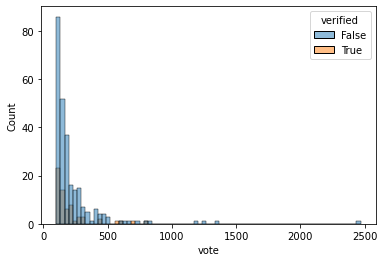

In [37]:
sns.histplot(x='vote',
             hue='verified',
             data=review_samples[review_samples['vote'] >= 100])
plt.show()

In [44]:
# Explore skew and kurtosis functions in pandas and scipy
pd_skew    = review_samples['vote'].skew()
pd_kurt    = review_samples['vote'].kurt()
sci_skew   = skew(review_samples['vote'], bias=False)
sci_kurt   = kurtosis(review_samples['vote'], bias=False)
sci_skew_b = skew(review_samples['vote'], bias=True)
sci_kurt_b = kurtosis(review_samples['vote'], bias=True)

pd.DataFrame({'skew': [pd_skew, sci_skew, sci_skew_b],
              'kurtosis': [pd_kurt, sci_kurt, sci_kurt_b]},
             index=['pandas', 'scipy-unbiased', 'scipy-biased']
            )

,skew,kurtosis
pandas,13.803361,347.782625
scipy-unbiased,13.803361,347.782625
scipy-biased,13.799652,347.470163


In [45]:
# Normalize vote variable
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

# Take the log10 of votes
review_samples['vote_norm'] = boxcox(review_samples['vote'], lmbda=0)

# Apply power transformation
pt = PowerTransformer()
review_samples['vote_power'] = pt.fit_transform(pd.DataFrame(review_samples['vote']))

/var/folders/y7/dvfckgnx3z38k75w9h5_1tdw0000gn/T/ipykernel_57793/441206571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_samples['vote_norm'] = boxcox(review_samples['vote'], lmbda=0)
/var/folders/y7/dvfckgnx3z38k75w9h5_1tdw0000gn/T/ipykernel_57793/441206571.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_samples['vote_power'] = pt.fit_transform(pd.DataFrame(review_samples['vote']))


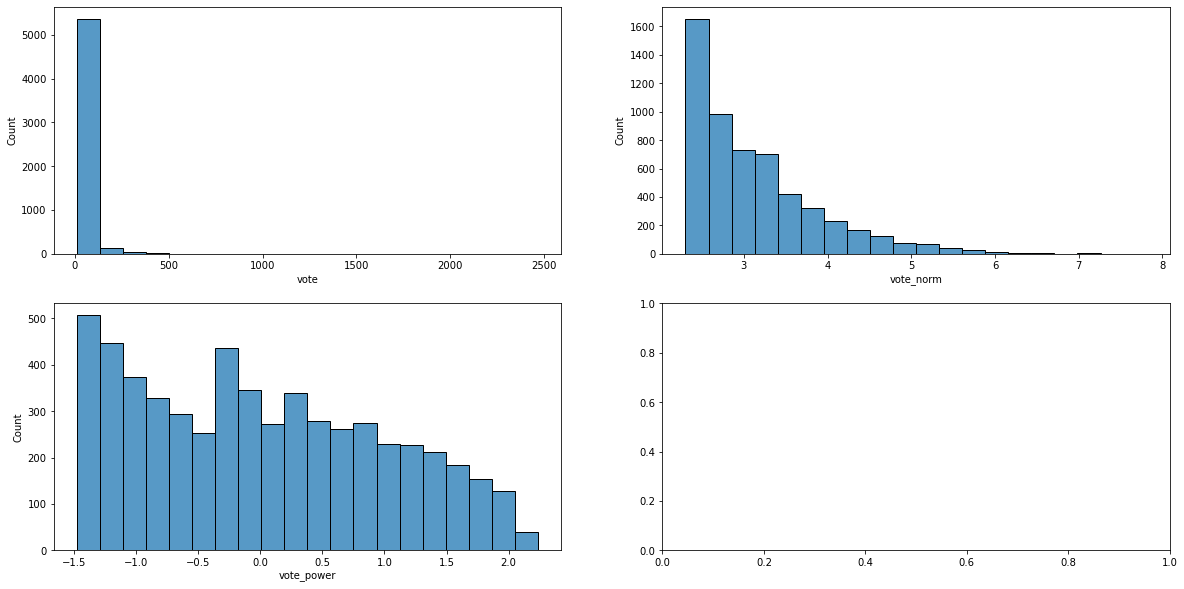

In [46]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.histplot(x='vote',
             data=review_samples,
             bins=20,
             ax=ax[0][0]
            )

sns.histplot(x='vote_norm',
             data=review_samples,
             bins=20,
             ax=ax[0][1]
            )

sns.histplot(x='vote_power',
             data=review_samples,
             bins=20,
             ax=ax[1][0]
            )

plt.show()

In [47]:
# Define the usefulness classification based on vote_power variable

review_samples['useful'] = review_samples['vote_power'].apply(lambda x: 1 if x > 0 else 0)
review_samples['useful'].value_counts()

0    2982
1    2601
Name: useful, dtype: int64

## 3. Text pre-processing

In [50]:
# Use html library to decode special characters
html_reviews = review_samples[review_samples['reviewText'].str.contains('&#', na=False)]

if html_reviews.empty:
    # Doesn't appear to be an issue in this data, but will use the else statement to check
    pass
else:
    # Show an example of the unescape function
    sample_review = html_reviews['reviewText'].iloc[0]
    print(sample_review)
    print("")
    decoded_review = html.unescape(sample_review)
    print(decoded_review)

In [51]:
# Remove special characters
pattern = r"\&\#[0-9]+\;"

review_samples["reviewText"] = review_samples["reviewText"].str.replace(pat=pattern, repl="", regex=True)

### 3.1 Lemmatization

In [52]:
# Use lemmatization to reduce words to their root form

# import nltk resources
resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource, quiet=True)

In [53]:
%%time
# create Lemmatizer object
lemma = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

# apply functions to review text
review_samples["reviewProcessed"] = review_samples["reviewText"].apply(lambda row: lemmatize_doc(row))

# Example review
print(review_samples["reviewText"].iloc[1])
print("")
print(review_samples["reviewProcessed"].iloc[1])
print("")

Confirming as of April 2010 - The magazines do NOT come packaged with the software CD's as pictured on the product page, nor does the description disclaim that this is some kind no-CD subscription of the magazine.

The reviews on the ridiculous time frames in which you receive your first issue are, unfortunately, true as well. The description claims 6-10 weeks, but it could take several months longer.

Falsely advertised; buy directly through Maximum PC or a more reliable source where you'll actually get all 12 months with all 12 software discs, rather than 6-10 issues with no discs.

This product is NOT the product described. It's as simple as that.

Confirming as of April 2010 - The magazine do NOT come package with the software CD s as picture on the product page nor do the description disclaim that this be some kind no-CD subscription of the magazine The review on the ridiculous time frame in which you receive your first issue be unfortunately true as well The description claim 6-1

### 3.2 General normalization

In [54]:
# Remove accents

remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
review_samples["reviewProcessed"] = review_samples["reviewProcessed"].apply(remove_accent)

# Remove punctuation
pattern = r"[^\w\s]"
review_samples["reviewProcessed"] = review_samples["reviewProcessed"].str.replace(pat=pattern, repl=" ", regex=True)

# Convert to lowercase
review_samples["reviewProcessed"] = review_samples["reviewProcessed"].str.lower()

# Remove stopwords
stop_words = stopwords.words("english")
stop_words = [word.replace("\'", "") for word in stop_words]
# print(f"sample stop words: {stop_words[:15]} \n")

remove_stop_words = lambda row: " ".join([token for token in row.split(" ") if token not in stop_words])
review_samples["reviewProcessed"] = review_samples["reviewProcessed"].apply(remove_stop_words)

# Remove extra spaces
pattern = r"[\s]+"
review_samples["reviewProcessed"] = review_samples["reviewProcessed"].str.replace(pat=pattern, repl=" ", regex=True)

# Example review
print(review_samples["reviewText"].iloc[1])
print("")
print(review_samples["reviewProcessed"].iloc[1])

Confirming as of April 2010 - The magazines do NOT come packaged with the software CD's as pictured on the product page, nor does the description disclaim that this is some kind no-CD subscription of the magazine.

The reviews on the ridiculous time frames in which you receive your first issue are, unfortunately, true as well. The description claims 6-10 weeks, but it could take several months longer.

Falsely advertised; buy directly through Maximum PC or a more reliable source where you'll actually get all 12 months with all 12 software discs, rather than 6-10 issues with no discs.

This product is NOT the product described. It's as simple as that.

confirming april 2010 magazine come package software cd picture product page description disclaim kind cd subscription magazine review ridiculous time frame receive first issue unfortunately true well description claim 6 10 week could take several month longer falsely advertise buy directly maximum pc reliable source actually get 12 month

### 3.3 Tokenization and vocabulary

In [ ]:
# Create corpora
corpora = review_samples['reviewText'].values
tokenized = [corpus.split(" ") for corpus in corpora]

In [ ]:
# Setup phrase modeling
bi_gram = Phrases(tokenized, min_count=300, threshold=50)

tri_gram = Phrases(bi_gram[tokenized], min_count=50, threshold=50)

In [ ]:
# Unigrams
uni_gram_tokens = set([token for text in tokenized for token in text])
uni_gram_tokens = set(filter(lambda x: x != "", uni_gram_tokens))

print(list(uni_gram_tokens)[:200])

In [ ]:
# Bigrams
bigram_min = bi_gram.min_count
bi_condition = lambda x: x[1] >= bigram_min

bi_gram_tokens = dict(filter(bi_condition, bi_gram.vocab.items()))
bi_gram_tokens = set(bi_gram_tokens)

bi_grams_only = bi_gram_tokens.difference(uni_gram_tokens)
print(list(bi_grams_only))

In [ ]:
# Trigrams 
trigram_min = tri_gram.min_count

tri_condition = lambda x: x[1] >= trigram_min

tri_gram_tokens = dict(filter(tri_condition, tri_gram.vocab.items()))
tri_gram_tokens = set(tri_gram_tokens)

tri_grams_only = tri_gram_tokens.difference(bi_gram_tokens)
print(list(tri_grams_only)[:50])

### X.X Output sampled and processed data to CSV

In [ ]:
review_samples.to_csv('data/review_samples.csv')

## X.X New data source 

Data description: https://s3.amazonaws.com/amazon-reviews-pds/readme.html  
Data dictionary and download: https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt

__Note:__ The potential advantage of this data is that usefulness can be calculated as a proportion rather than an absolute. Whereas the original data only provides the total # of votes for usefulness, this data provides the total votes for usefulness and the total overall votes.

In [9]:
sample = pd.read_csv("../data/sample_us.tsv", sep='\t')
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        49 non-null     object
 1   customer_id        49 non-null     int64 
 2   review_id          49 non-null     object
 3   product_id         49 non-null     object
 4   product_parent     49 non-null     int64 
 5   product_title      49 non-null     object
 6   product_category   49 non-null     object
 7   star_rating        49 non-null     int64 
 8   helpful_votes      49 non-null     int64 
 9   total_votes        49 non-null     int64 
 10  vine               49 non-null     object
 11  verified_purchase  49 non-null     object
 12  review_headline    49 non-null     object
 13  review_body        49 non-null     object
 14  review_date        49 non-null     object
dtypes: int64(5), object(10)
memory usage: 5.9+ KB


In [12]:
sample[['star_rating', 'review_headline', 'review_body']].head()

,star_rating,review_headline,review_body
0,5,Five Stars,Excellent!!!
1,5,Good quality track at excellent price,Great quality wooden track (better than some o...
2,2,Two Stars,Cards are not as big as pictured.
3,5,my daughter loved it and i liked the price and...,my daughter loved it and i liked the price and...
4,1,DONT BUY THESE!,Do not buy these! They break very fast I spun ...


__DATA COLUMNS:__  
__marketplace__       - 2 letter country code of the marketplace where the review was written.  
__customer_id__       - Random identifier that can be used to aggregate reviews written by a single author.  
__review_id__         - The unique ID of the review.  
__product_id__        - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.  
__product_parent__    - Random identifier that can be used to aggregate reviews for the same product.  
__product_title__     - Title of the product.  
__product_category__  - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts).  
__star_rating__       - The 1-5 star rating of the review.  
__helpful_votes__     - Number of helpful votes.  
__total_votes__       - Number of total votes the review received.  
__vine__              - Review was written as part of the Vine program.  
__verified_purchase__ - The review is on a verified purchase.  
__review_headline__   - The title of the review.  
__review_body__       - The review text.  
__review_date__       - The date the review was written.  

In [ ]:
sample['useful'] = sample['helpful_votes'] / sample['total_votes']
sample['useful'] = sample['useful'].fillna(0)

In [ ]:
sns.lmplot(x='total_votes', y='useful', data=sample, hue='product_category', fit_reg=False)\
   .set(title='')

plt.show()